In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import textwrap
from datetime import datetime,date
import warnings
warnings.filterwarnings("ignore")

## CONEXIONES SQL SERVER AND SHEETS FORMS

In [2]:
inicio_tem_2022_1 = '2022-04-01'
fin_tem_2022_1 = '2022-07-31'

inicio_tem_2022_2 = '2022-11-23'
fin_tem_2022_2 = '2023-01-31'

In [5]:
# QUERY MAREAS ACODERE
driver = '{ODBC Driver 17 for SQL Server}'
server = 'srv-db-east-repl001.database.windows.net'
database_name = 'db_cfa_prd01'
user = 'userpowerbi'
password = '#p4ssw0rdp0w3rb1#'

connection_string = textwrap.dedent('''
    Driver={driver};
    Server={server};
    Database={database_name};
    Uid={user};
    Pwd={password};
    Encrypt=yes;
    TrustServerCertificate=no;
'''.format(driver=driver,server=server,database_name=database_name,user=user,password=password))

conn = pyodbc.connect(connection_string)

cursor = conn.cursor()

cursor.execute("""SELECT marea_id as MAREA,
       DATEADD(HOUR,-5,acodera_chata) AS ACODERA,
	     DATEADD(HOUR,-5,inicio_succion) AS INICIO_SUCCION,
	   DATEADD(HOUR,-5,termino_succion) AS TERMINO_SUCCION,
	   CASE WHEN DATEADD(HOUR,-5,acodera_chata) >= '{a}' AND DATEADD(HOUR,-5,acodera_chata) <= '{b}' THEN '2022 - I' 
	   WHEN DATEADD(HOUR,-5,acodera_chata) >= '{c}' AND DATEADD(HOUR,-5,acodera_chata) <= '{d}' THEN '2022 - II'
	   ELSE 'OTHER' END AS TEMPORADA
       FROM dbo.MareasAcodere
       WHERE DATEADD(HOUR,-5,acodera_chata) >= '{inicio}'""".format(a=inicio_tem_2022_1,b=fin_tem_2022_1,c=inicio_tem_2022_2,d=fin_tem_2022_2,inicio=inicio_tem_2022_1))

In [6]:
df_mareas = pd.DataFrame.from_records(cursor.fetchall(), columns=[col[0] for col in cursor.description])
df_mareas['MAREA'] = pd.to_numeric(df_mareas['MAREA'])
df_mareas = df_mareas[~df_mareas['MAREA'].duplicated()]
cursor.close()
df_mareas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7049 entries, 0 to 7048
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            7049 non-null   int64         
 1   ACODERA          7049 non-null   datetime64[ns]
 2   INICIO_SUCCION   7042 non-null   datetime64[ns]
 3   TERMINO_SUCCION  6991 non-null   datetime64[ns]
 4   TEMPORADA        7049 non-null   object        
dtypes: datetime64[ns](3), int64(1), object(1)
memory usage: 330.4+ KB


In [7]:
# QUERY CHI
driver = '{ODBC Driver 17 for SQL Server}'
server = 'srv-db-east-us-tasa-his-02.database.windows.net'
database_name = 'db_bi_production_prd'
user = 'userpowerbi'
password = '#p4ssw0rdp0w3rb1#'

connection_string = textwrap.dedent('''
    Driver={driver};
    Server={server};
    Database={database_name};
    Uid={user};
    Pwd={password};
    Encrypt=yes;
    TrustServerCertificate=no;
'''.format(driver=driver,server=server,database_name=database_name,user=user,password=password))

conn = pyodbc.connect(connection_string)

cursor = conn.cursor()

cursor.execute("""SELECT 
        MAREA, 
        PLANTA,
        CAST(F_ARRIB AS DATETIME) + CAST(H_ARRIB AS DATETIME) AS FECHA_ARRIBO,
        CASE WHEN D_INICI < H_ARRIB THEN CAST(DATEADD(DAY,1,F_ARRIB) AS DATETIME) + CAST(D_INICI AS DATETIME) ELSE CAST(F_ARRIB AS DATETIME) + CAST(D_INICI AS DATETIME) END AS INICIO_DESCARGA,
        CASE WHEN D_FINAL < D_INICI AND D_INICI < H_ARRIB THEN CAST(DATEADD(DAY,2,F_ARRIB) AS DATETIME) + CAST(D_FINAL AS DATETIME) 
         WHEN D_FINAL < D_INICI AND D_INICI > H_ARRIB THEN CAST(DATEADD(DAY,1,F_ARRIB) AS DATETIME) + CAST(D_FINAL AS DATETIME) 
         WHEN D_FINAL > D_INICI AND D_INICI < H_ARRIB THEN CAST(DATEADD(DAY,1,F_ARRIB) AS DATETIME) + CAST(D_FINAL AS DATETIME)
         ELSE CAST(F_ARRIB AS DATETIME) + CAST(D_FINAL AS DATETIME) END AS FIN_DESCARGA
        FROM sap.ZQM_DESC_MP_CHI
        WHERE FECHA >= '{inicio}' AND MAREA <> 0""".format(inicio=inicio_tem_2022_1))

In [8]:
df_chi = pd.DataFrame.from_records(cursor.fetchall(), columns=[col[0] for col in cursor.description])
df_chi['MAREA'] = pd.to_numeric(df_chi['MAREA'])
df_chi['PLANTA'] = df_chi['PLANTA'].str.split(' ').str[0].str.upper()
df_chi = df_chi[~df_chi['MAREA'].duplicated()]
cursor.close()
df_chi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7074 entries, 0 to 7099
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            7074 non-null   int64         
 1   PLANTA           7074 non-null   object        
 2   FECHA_ARRIBO     7074 non-null   datetime64[ns]
 3   INICIO_DESCARGA  7074 non-null   datetime64[ns]
 4   FIN_DESCARGA     7074 non-null   datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(1)
memory usage: 331.6+ KB


In [9]:
df_bitacora = pd.merge(df_mareas,df_chi, on=["MAREA"],how='inner')
df_bitacora.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7025 entries, 0 to 7024
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            7025 non-null   int64         
 1   ACODERA          7025 non-null   datetime64[ns]
 2   INICIO_SUCCION   7020 non-null   datetime64[ns]
 3   TERMINO_SUCCION  6973 non-null   datetime64[ns]
 4   TEMPORADA        7025 non-null   object        
 5   PLANTA           7025 non-null   object        
 6   FECHA_ARRIBO     7025 non-null   datetime64[ns]
 7   INICIO_DESCARGA  7025 non-null   datetime64[ns]
 8   FIN_DESCARGA     7025 non-null   datetime64[ns]
dtypes: datetime64[ns](6), int64(1), object(2)
memory usage: 548.8+ KB


In [10]:
def solve_datetime_sheets(datetime_s):
 
    year = (datetime_s).year #2022
    mon = (datetime_s).month #02
    day = (datetime_s).day  #12
    hour = (datetime_s).hour
    minute = (datetime_s).minute
    second = (datetime_s).second

    if (( day == 12) & (mon < day)  ):
        return datetime(year, day, mon,hour,minute,second)
    else:
        return datetime(year, mon, day,hour,minute,second)

In [11]:
# FORMS QUERY
df_forms_dgsante = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRsp2vmTU-CMxMpwWAui3SohhzlVSfQF-s5vGO3H8tkmFPjrKZk8ZZ47xflO-YQf4uMIkvVTiEX3aAe/pub?gid=0&single=true&output=csv')

df_forms_dgsante['1 - INICIO DE ANÁLISIS 1 -INICIO DE ANÁLISIS'] = pd.to_datetime(df_forms_dgsante['1 - INICIO DE ANÁLISIS 1 -INICIO DE ANÁLISIS'])
df_forms_dgsante['2 - FIN DE ANÁLISIS 2 - FIN DE ANÁLISIS'] = pd.to_datetime(df_forms_dgsante['2 - FIN DE ANÁLISIS 2 - FIN DE ANÁLISIS'])

df_forms_dgsante.rename(columns={'1 - INICIO DE ANÁLISIS 1 -INICIO DE ANÁLISIS':'INICIO_ANALISIS'},inplace = True)
df_forms_dgsante.rename(columns={'2 - FIN DE ANÁLISIS 2 - FIN DE ANÁLISIS':'FIN_ANALISIS'},inplace = True)

df_forms_dgsante['INICIO_ANALISIS'] = df_forms_dgsante['INICIO_ANALISIS'].apply(lambda x:  solve_datetime_sheets(x.to_pydatetime()))
df_forms_dgsante['FIN_ANALISIS'] = df_forms_dgsante['FIN_ANALISIS'].apply(lambda x:  solve_datetime_sheets(x.to_pydatetime()))

df_forms_dgsante = df_forms_dgsante[~df_forms_dgsante['MAREA'].duplicated()]

df_forms_dgsante.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936 entries, 0 to 2097
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            1935 non-null   float64       
 1   PLANTA           1935 non-null   object        
 2   EMBARCACIÓN      1935 non-null   object        
 3   INICIO_ANALISIS  1936 non-null   datetime64[ns]
 4   FIN_ANALISIS     1936 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 90.8+ KB


In [12]:
df_tasa = pd.merge(df_bitacora,df_forms_dgsante, on=["MAREA","PLANTA"],how='left')
df_tasa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7025 entries, 0 to 7024
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            7025 non-null   int64         
 1   ACODERA          7025 non-null   datetime64[ns]
 2   INICIO_SUCCION   7020 non-null   datetime64[ns]
 3   TERMINO_SUCCION  6973 non-null   datetime64[ns]
 4   TEMPORADA        7025 non-null   object        
 5   PLANTA           7025 non-null   object        
 6   FECHA_ARRIBO     7025 non-null   datetime64[ns]
 7   INICIO_DESCARGA  7025 non-null   datetime64[ns]
 8   FIN_DESCARGA     7025 non-null   datetime64[ns]
 9   EMBARCACIÓN      1870 non-null   object        
 10  INICIO_ANALISIS  1870 non-null   datetime64[ns]
 11  FIN_ANALISIS     1870 non-null   datetime64[ns]
dtypes: datetime64[ns](8), int64(1), object(3)
memory usage: 713.5+ KB


In [13]:
df_tasa = df_tasa[~df_tasa['INICIO_SUCCION'].isnull()]
df_tasa = df_tasa[df_tasa['TEMPORADA']!='OTHER']
df_tasa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6847 entries, 0 to 7024
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MAREA            6847 non-null   int64         
 1   ACODERA          6847 non-null   datetime64[ns]
 2   INICIO_SUCCION   6847 non-null   datetime64[ns]
 3   TERMINO_SUCCION  6804 non-null   datetime64[ns]
 4   TEMPORADA        6847 non-null   object        
 5   PLANTA           6847 non-null   object        
 6   FECHA_ARRIBO     6847 non-null   datetime64[ns]
 7   INICIO_DESCARGA  6847 non-null   datetime64[ns]
 8   FIN_DESCARGA     6847 non-null   datetime64[ns]
 9   EMBARCACIÓN      1870 non-null   object        
 10  INICIO_ANALISIS  1870 non-null   datetime64[ns]
 11  FIN_ANALISIS     1870 non-null   datetime64[ns]
dtypes: datetime64[ns](8), int64(1), object(3)
memory usage: 695.4+ KB


In [14]:
def values_total(x,df):
    all = df[x].value_counts()
    percentage = all/len(df)*100
    df_mv = pd.DataFrame(data=[all,percentage])
    df_mv = df_mv.T
    df_mv.columns = ['Values','Percentage']
    return df_mv.sort_index()

## EVALUACIÓN DE KPIS - PROCESO ACODERA A INICIO_SUCCION

In [15]:
def barplot_df(x,y,df,title):
    ax = sns.barplot(x=x,y=y,data=df)
    plt.title(title,fontsize=10)
    ax.bar_label(ax.containers[0])

In [16]:
def barplot_df_hue(x,y,hue,df,title):
    plt.figure(figsize=(10,10))
    ax = sns.barplot(x=x,y=y,hue=hue,data=df)
    plt.title(title,fontsize=10)
    for i in ax.containers:
        ax.bar_label(i,)

In [17]:
df1 = df_tasa[['PLANTA','TEMPORADA','ACODERA','INICIO_SUCCION']]
df1['P'] = (df1['INICIO_SUCCION'] - df1['ACODERA'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA'],as_index=False).agg({'P':'mean'})
df1.rename(columns = {'P':'X̅ P'}, inplace = True)
df1['X̅ P'] = df1['X̅ P'].round()
df1 = df1.sort_index()
df1

,TEMPORADA,X̅ P
0,2022 - I,20.0
1,2022 - II,22.0


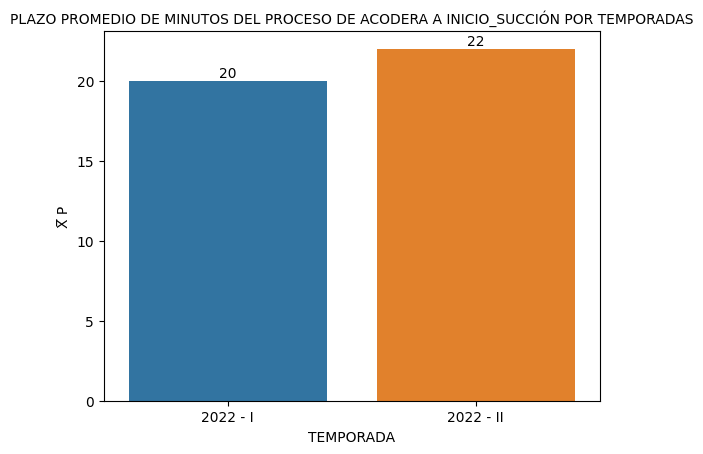

In [18]:
barplot_df('TEMPORADA','X̅ P',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE ACODERA A INICIO_SUCCIÓN POR TEMPORADAS')

In [19]:
df1 = df_tasa[['PLANTA','TEMPORADA','ACODERA','INICIO_SUCCION']]
df1['P'] = (df1['INICIO_SUCCION'] - df1['ACODERA'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','PLANTA'],as_index=False).agg({'P':'mean'})
df1.rename(columns = {'P':'X̅ P'}, inplace = True)
df1['X̅ P'] = df1['X̅ P'].round()
df1 = df1.sort_index()
df1

,TEMPORADA,PLANTA,X̅ P
0,2022 - I,CALLAO,19.0
1,2022 - I,CHIMBOTE,18.0
2,2022 - I,MALABRIGO,22.0
3,2022 - I,MATARANI,13.0
4,2022 - I,PISCO,24.0
5,2022 - I,SAMANCO,21.0
6,2022 - I,SUPE,28.0
7,2022 - I,VEGUETA,20.0
8,2022 - II,CALLAO,20.0
9,2022 - II,CHIMBOTE,23.0


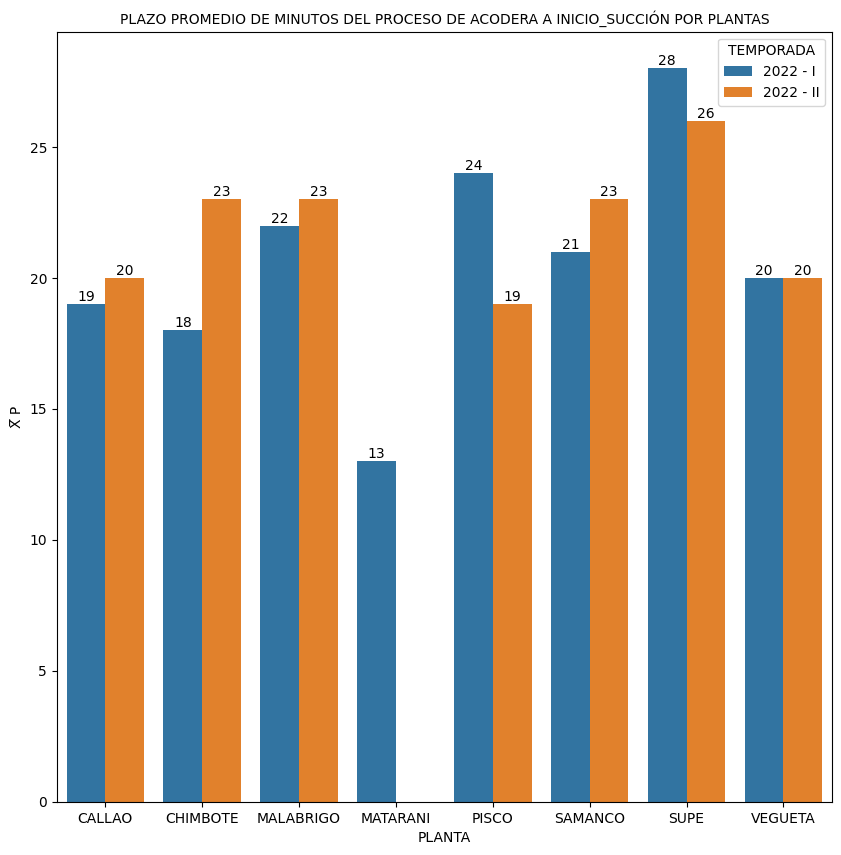

In [20]:
barplot_df_hue('PLANTA','X̅ P','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE ACODERA A INICIO_SUCCIÓN POR PLANTAS')

## EVALUACIÓN DE LOS TIEMPOS DE INICIO_SUCCION CON INICIO_DESCARGA

In [21]:
df_tasa['INISUCCION_INIDESCARGA_CORRECTO'] = np.where(df_tasa['INICIO_DESCARGA'] < df_tasa['INICIO_SUCCION'],0,1)
df_tasa['INISUCCION_INIDESCARGA_MIN'] = (df_tasa['INICIO_DESCARGA'] - df_tasa['INICIO_SUCCION'] ).dt.total_seconds() / 60.0

In [22]:
def boxplot_df(df,x,title):
    sns.boxplot(x=df[x]).set(title=title)

In [23]:
def piechart_percentage(df,title):
    labels = ['Inconforme','Conforme']
    colors = ('#bb2124','#5bc0de')
    plt.title(title,fontsize=10)
    plt.pie(df['Percentage'], labels=labels, colors=colors,autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.axis('equal')  
    plt.show()

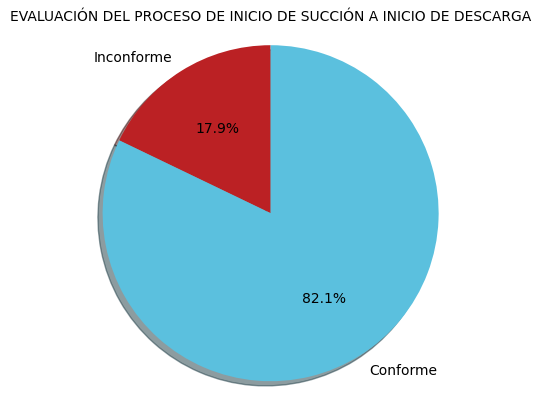

In [24]:
piechart_percentage(values_total('INISUCCION_INIDESCARGA_CORRECTO',df_tasa),'EVALUACIÓN DEL PROCESO DE INICIO DE SUCCIÓN A INICIO DE DESCARGA')

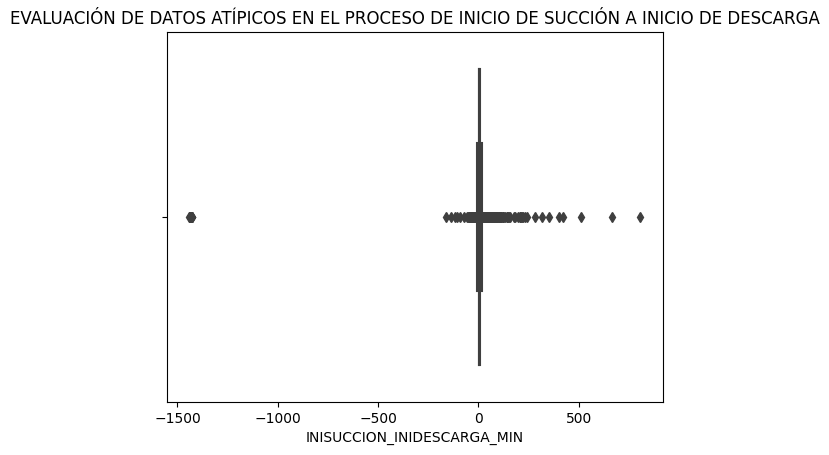

In [25]:
boxplot_df(df_tasa,'INISUCCION_INIDESCARGA_MIN','EVALUACIÓN DE DATOS ATÍPICOS EN EL PROCESO DE INICIO DE SUCCIÓN A INICIO DE DESCARGA')

In [26]:
def identify_outliers(df):
  for i in df.describe().columns:
    Q1 = df.describe().at['25%', i]
    Q3 = df.describe().at['75%', i]
    IQR = Q3-Q1
    LTV = Q1 - 1.5 * IQR 
    UTV = Q3 + 1.5 * IQR 
    print('Nombre de Columna                                         :', i)
    print('Rango Intercuartil IQR                                    :', IQR)
    print('Limite Inferior                                           :', LTV)
    print('Limite Superior                                           :', UTV)
    print('Número de outliers por debajo del bigote inferior         :', df[df[i] < LTV][i].count())
    print('Número de outliers por encima del bigote superior         :', df[df[i] > UTV][i].count())
    print('Total de Ourliers                                         :', (df[df[i] < LTV][i].count()) + (df[df[i] > UTV][i].count()))
    print('\n')

In [27]:
def select_values_outliers(df):
  for i in df.describe().columns:
    Q1 = df.describe().at['25%', i]
    Q3 = df.describe().at['75%', i]
    IQR = Q3-Q1
    LTV = Q1 - 1.5 * IQR 
    UTV = Q3 + 1.5 * IQR 
    return LTV,UTV

In [28]:
identify_outliers(df_tasa['INISUCCION_INIDESCARGA_MIN'].to_frame())

Nombre de Columna                                         : INISUCCION_INIDESCARGA_MIN
Rango Intercuartil IQR                                    : 7.0
Limite Inferior                                           : -9.5
Limite Superior                                           : 18.5
Número de outliers por debajo del bigote inferior         : 180
Número de outliers por encima del bigote superior         : 667
Total de Ourliers                                         : 847




In [29]:
LTV,UTV = select_values_outliers(df_tasa['INISUCCION_INIDESCARGA_MIN'].to_frame())
df_tasa['ATIPICO_INISUCCION_INIDESCARGA'] = np.where((df_tasa['INISUCCION_INIDESCARGA_MIN'] < LTV) | (df_tasa['INISUCCION_INIDESCARGA_MIN'] > UTV),1,0)

In [30]:
values_total('ATIPICO_INISUCCION_INIDESCARGA',df_tasa)

,Values,Percentage
0,6000.0,87.629619
1,847.0,12.370381


In [31]:
def histplot_df_hue(df,x,hue,title):
    sns.histplot(df, x=x, hue=hue).set(title=title)

In [32]:
def histplot_df(df,x,title):
    sns.histplot(df, x=x,binwidth=3).set(title=title)

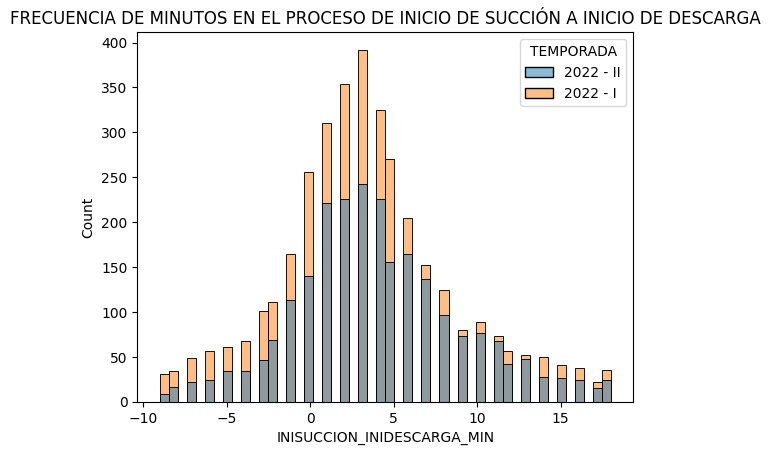

In [33]:
histplot_df_hue(df_tasa[df_tasa['ATIPICO_INISUCCION_INIDESCARGA']==0],'INISUCCION_INIDESCARGA_MIN','TEMPORADA','FRECUENCIA DE MINUTOS EN EL PROCESO DE INICIO DE SUCCIÓN A INICIO DE DESCARGA')

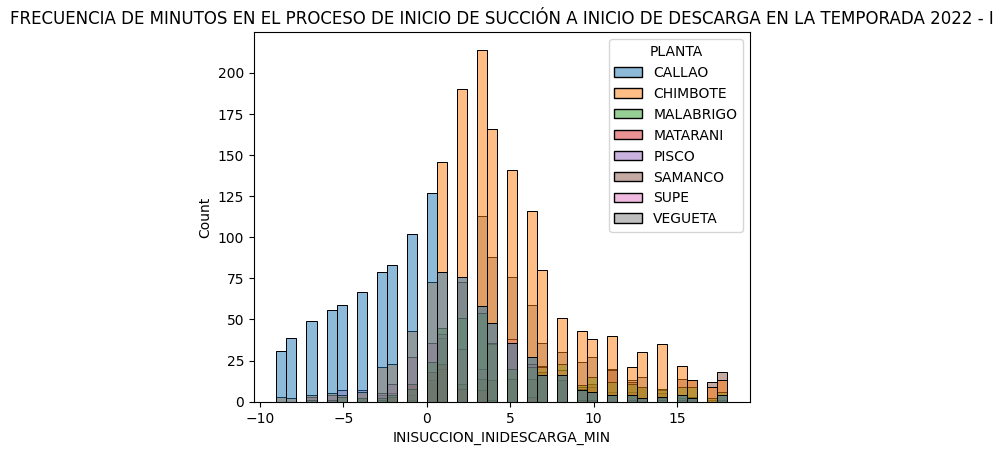

In [32]:
histplot_df_hue(df_tasa[ (df_tasa['ATIPICO_INISUCCION_INIDESCARGA']==0)].sort_values(by='PLANTA'),'INISUCCION_INIDESCARGA_MIN','PLANTA','FRECUENCIA DE MINUTOS EN EL PROCESO DE INICIO DE SUCCIÓN A INICIO DE DESCARGA EN LA TEMPORADA 2022 - I')

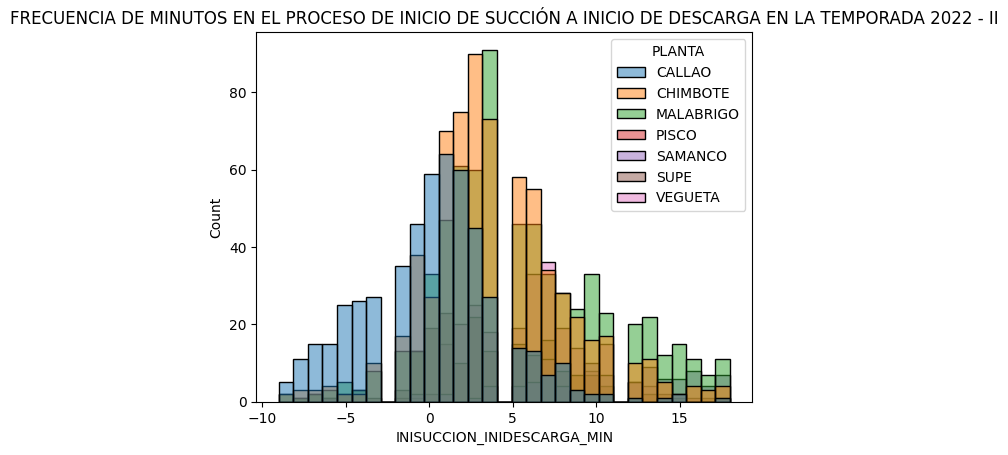

In [34]:
histplot_df_hue(df_tasa[ (df_tasa['ATIPICO_INISUCCION_INIDESCARGA']==0) & (df_tasa['TEMPORADA'] == '2022 - II')].sort_values(by='PLANTA'),'INISUCCION_INIDESCARGA_MIN','PLANTA','FRECUENCIA DE MINUTOS EN EL PROCESO DE INICIO DE SUCCIÓN A INICIO DE DESCARGA EN LA TEMPORADA 2022 - II')

 ## EVALUACIÓN DE KPIS =  FIN DE ANÁLISIS A INICIO DE SUCCIÓN

In [35]:
# Limpiando los atipicos de INICIO DE SUCCIÓN
df_tasa2 = df_tasa[~df_tasa['INICIO_ANALISIS'].isnull()]
df_tasa2 = df_tasa2[df_tasa2['ATIPICO_INISUCCION_INIDESCARGA']==0]
df_tasa2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1661 entries, 0 to 7024
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   MAREA                            1661 non-null   int64         
 1   ACODERA                          1661 non-null   datetime64[ns]
 2   INICIO_SUCCION                   1661 non-null   datetime64[ns]
 3   TERMINO_SUCCION                  1656 non-null   datetime64[ns]
 4   TEMPORADA                        1661 non-null   object        
 5   PLANTA                           1661 non-null   object        
 6   FECHA_ARRIBO                     1661 non-null   datetime64[ns]
 7   INICIO_DESCARGA                  1661 non-null   datetime64[ns]
 8   FIN_DESCARGA                     1661 non-null   datetime64[ns]
 9   EMBARCACIÓN                      1661 non-null   object        
 10  INICIO_ANALISIS                  1661 non-null   datetime64[

In [36]:
df_tasa2['FINANALISIS_INISUCCION_CORRECTO'] = np.where(df_tasa2['FIN_ANALISIS'] > df_tasa2['INICIO_SUCCION'],0,1) 
df_tasa2['FINANALISIS_INISUCCION_MIN'] = (df_tasa2['INICIO_SUCCION'] - df_tasa2['FIN_ANALISIS'] ).dt.total_seconds() / 60.0

In [37]:
def countplot_percentage_hue(x,hue,df,title):
    df = df.groupby(x)[hue].value_counts(normalize=True)
    df = df.mul(100)
    df = df.rename('percent').reset_index()
    
    g = sns.catplot(x=x,y='percent',hue=hue, kind='bar',data=df)
 
    plt.title(title, fontsize=10)
    for p in g.ax.patches:
        percentage = str((p.get_height().round()).astype(int)) + '%'
        x = p.get_x()+ 0.015
        y = p.get_height() * 1.02
        g.ax.annotate(percentage, (x, y),color='black', rotation='horizontal')
    plt.show()

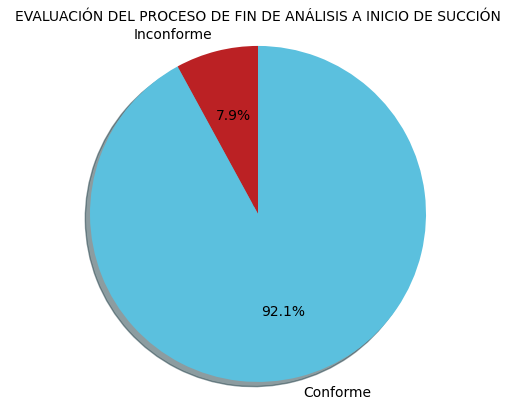

In [38]:
piechart_percentage(values_total('FINANALISIS_INISUCCION_CORRECTO',df_tasa2),'EVALUACIÓN DEL PROCESO DE FIN DE ANÁLISIS A INICIO DE SUCCIÓN')

In [39]:
values_total('FINANALISIS_INISUCCION_CORRECTO',df_tasa2)

,Values,Percentage
0,132.0,7.94702
1,1529.0,92.05298


In [40]:
df_tasa2[(df_tasa2['FINANALISIS_INISUCCION_CORRECTO'] == 0) ][['MAREA','PLANTA','FIN_ANALISIS','INICIO_SUCCION','FINANALISIS_INISUCCION_MIN']].sort_values(by='FINANALISIS_INISUCCION_MIN')

,MAREA,PLANTA,FIN_ANALISIS,INICIO_SUCCION,FINANALISIS_INISUCCION_MIN
6856,188198,MALABRIGO,2022-12-29 23:59:00,2022-12-28 23:30:00,-1469.0
6263,186307,CALLAO,2022-12-07 20:56:00,2022-12-06 20:52:00,-1444.0
5266,187064,CALLAO,2022-12-15 22:21:00,2022-12-14 22:21:00,-1440.0
5331,187113,CALLAO,2022-12-15 20:18:00,2022-12-14 20:19:00,-1439.0
6111,186270,CALLAO,2022-12-07 21:03:00,2022-12-06 21:05:00,-1438.0
...,...,...,...,...,...
6126,186155,MALABRIGO,2022-12-05 20:31:00,2022-12-05 20:30:00,-1.0
5190,187187,SUPE,2022-12-16 00:26:00,2022-12-16 00:25:00,-1.0
5240,186925,VEGUETA,2022-12-12 18:51:00,2022-12-12 18:50:00,-1.0
6794,188140,SUPE,2022-12-27 23:01:00,2022-12-27 23:00:00,-1.0


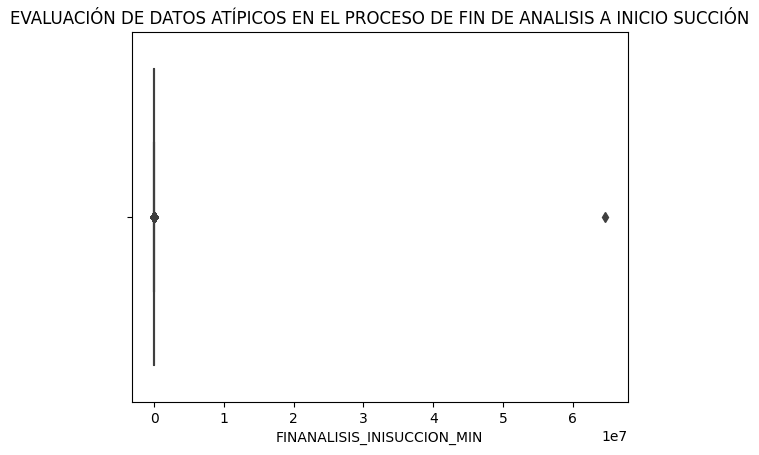

In [41]:
boxplot_df(df_tasa2,'FINANALISIS_INISUCCION_MIN','EVALUACIÓN DE DATOS ATÍPICOS EN EL PROCESO DE FIN DE ANALISIS A INICIO SUCCIÓN')

In [42]:
identify_outliers(df_tasa2['FINANALISIS_INISUCCION_MIN'].to_frame())

Nombre de Columna                                         : FINANALISIS_INISUCCION_MIN
Rango Intercuartil IQR                                    : 22.0
Limite Inferior                                           : -28.0
Limite Superior                                           : 60.0
Número de outliers por debajo del bigote inferior         : 50
Número de outliers por encima del bigote superior         : 164
Total de Ourliers                                         : 214




In [43]:
LTV,UTV = select_values_outliers(df_tasa2['FINANALISIS_INISUCCION_MIN'].to_frame())
df_tasa2['ATIPICO_FINANALISIS_INISUCCION'] = np.where((df_tasa2['FINANALISIS_INISUCCION_MIN'] < LTV) | (df_tasa2['FINANALISIS_INISUCCION_MIN'] > UTV),1,0)

In [44]:
values_total('ATIPICO_FINANALISIS_INISUCCION',df_tasa2)

,Values,Percentage
0,1447.0,87.116195
1,214.0,12.883805


In [45]:
df1 = df_tasa2[df_tasa2['ATIPICO_FINANALISIS_INISUCCION'] == 0][['TEMPORADA','PLANTA','FIN_ANALISIS','INICIO_SUCCION']]
df1['K'] = (df1['INICIO_SUCCION'] - df1['FIN_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = df1['X̅ K'].round()
df1 = df1.sort_index()
df1

,TEMPORADA,X̅ K
0,2022 - II,15.0


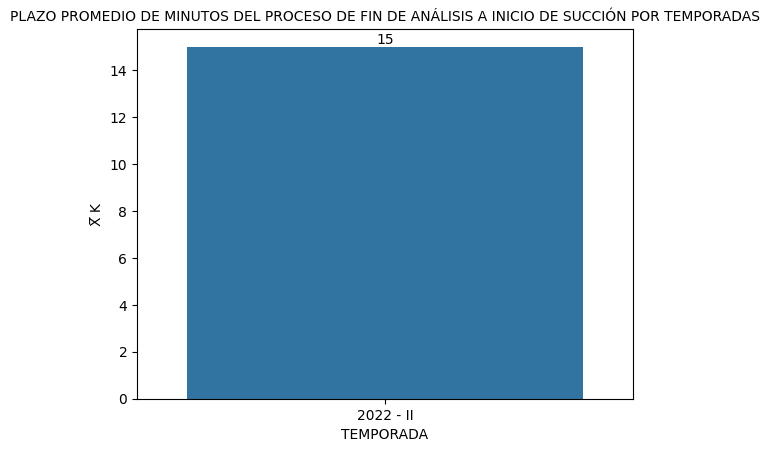

In [45]:
barplot_df('TEMPORADA','X̅ K',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE FIN DE ANÁLISIS A INICIO DE SUCCIÓN POR TEMPORADAS')

In [46]:
df1 = df_tasa2[df_tasa2['ATIPICO_FINANALISIS_INISUCCION'] == 0][['PLANTA','TEMPORADA','FIN_ANALISIS','INICIO_SUCCION']]
df1['K'] = (df1['INICIO_SUCCION'] - df1['FIN_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','PLANTA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = df1['X̅ K'].round()
df1 = df1.sort_index()
df1

,TEMPORADA,PLANTA,X̅ K
0,2022 - II,CALLAO,12.0
1,2022 - II,CHIMBOTE,18.0
2,2022 - II,MALABRIGO,16.0
3,2022 - II,SAMANCO,16.0
4,2022 - II,SUPE,12.0
5,2022 - II,VEGUETA,15.0


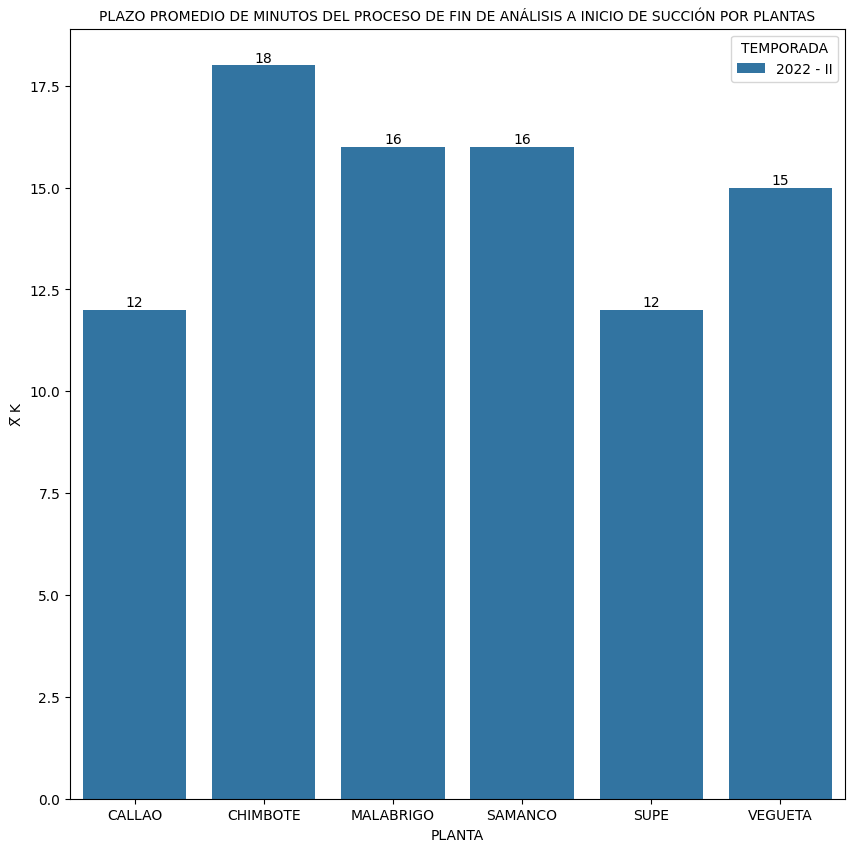

In [47]:
barplot_df_hue('PLANTA','X̅ K','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE FIN DE ANÁLISIS A INICIO DE SUCCIÓN POR PLANTAS')

## EVALUACIÓN DE KPIS - PROCESO INICIO ANALISIS A INICIO SUCCION

In [48]:
# Limpiando los atipicos de INICIO DE SUCCIÓN
df_tasa2 = df_tasa[~df_tasa['INICIO_ANALISIS'].isnull()]
df_tasa2 = df_tasa2[df_tasa2['ATIPICO_INISUCCION_INIDESCARGA']==0]
df_tasa2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558 entries, 4442 to 5272
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   MAREA                            558 non-null    int64         
 1   ACODERA                          558 non-null    datetime64[ns]
 2   INICIO_SUCCION                   558 non-null    datetime64[ns]
 3   TERMINO_SUCCION                  557 non-null    datetime64[ns]
 4   TEMPORADA                        558 non-null    object        
 5   PLANTA                           558 non-null    object        
 6   FECHA_ARRIBO                     558 non-null    datetime64[ns]
 7   INICIO_DESCARGA                  558 non-null    datetime64[ns]
 8   FIN_DESCARGA                     558 non-null    datetime64[ns]
 9   EMBARCACIÓN                      558 non-null    object        
 10  INICIO_ANALISIS                  558 non-null    datetime6

In [49]:
df_tasa2['INIANALISIS_INISUCCION_CORRECTO'] = np.where(df_tasa2['INICIO_ANALISIS'] > df_tasa2['INICIO_SUCCION'],0,1) 
df_tasa2['INIANALISIS_INISUCCION_MIN'] = (df_tasa2['INICIO_SUCCION'] - df_tasa2['INICIO_ANALISIS'] ).dt.total_seconds() / 60.0

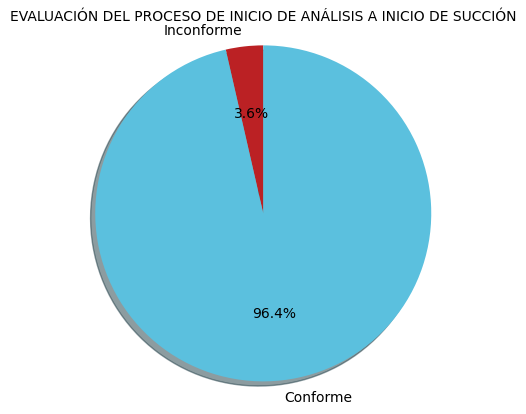

In [50]:
piechart_percentage(values_total('INIANALISIS_INISUCCION_CORRECTO',df_tasa2),'EVALUACIÓN DEL PROCESO DE INICIO DE ANÁLISIS A INICIO DE SUCCIÓN')

In [51]:
values_total('INIANALISIS_INISUCCION_CORRECTO',df_tasa2)

,Values,Percentage
0,20.0,3.584229
1,538.0,96.415771


In [52]:
df_tasa2[(df_tasa2['INIANALISIS_INISUCCION_CORRECTO'] == 0) ][['MAREA','PLANTA','INICIO_ANALISIS','INICIO_SUCCION','INIANALISIS_INISUCCION_MIN']].sort_values(by='INIANALISIS_INISUCCION_MIN')

,MAREA,PLANTA,INICIO_ANALISIS,INICIO_SUCCION,INIANALISIS_INISUCCION_MIN
4750,185541,CHIMBOTE,2022-11-30 23:53:00,2022-11-30 00:11:00,-1422.0
4789,185550,CHIMBOTE,2022-11-30 23:58:00,2022-11-30 00:25:00,-1413.0
4645,185394,CALLAO,2022-11-28 12:30:00,2022-11-28 01:00:00,-690.0
4646,185345,CALLAO,2022-11-28 12:43:00,2022-11-28 01:17:00,-686.0
4744,185498,CALLAO,2022-11-29 19:02:00,2022-11-29 17:07:00,-115.0
5064,185713,CHIMBOTE,2022-12-01 20:20:00,2022-12-01 19:38:00,-42.0
4879,185433,CHIMBOTE,2022-11-28 17:10:00,2022-11-28 16:52:00,-18.0
4494,185231,CALLAO,2022-11-26 18:43:00,2022-11-26 18:35:00,-8.0
4997,185901,CHIMBOTE,2022-12-02 16:55:00,2022-12-02 16:48:00,-7.0
5137,185872,CALLAO,2022-12-02 11:46:00,2022-12-02 11:41:00,-5.0


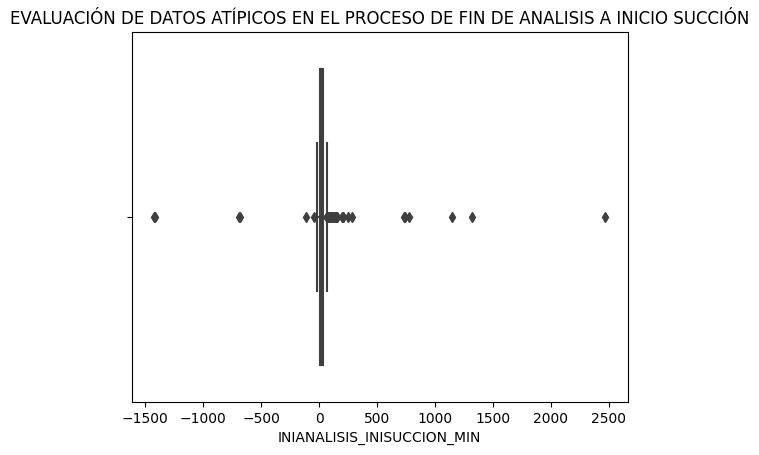

In [53]:
boxplot_df(df_tasa2,'INIANALISIS_INISUCCION_MIN','EVALUACIÓN DE DATOS ATÍPICOS EN EL PROCESO DE FIN DE ANALISIS A INICIO SUCCIÓN')

In [54]:
identify_outliers(df_tasa2['INIANALISIS_INISUCCION_MIN'].to_frame())

Nombre de Columna                                         : INIANALISIS_INISUCCION_MIN
Rango Intercuartil IQR                                    : 23.0
Limite Inferior                                           : -26.5
Limite Superior                                           : 65.5
Número de outliers por debajo del bigote inferior         : 6
Número de outliers por encima del bigote superior         : 50
Total de Ourliers                                         : 56




In [55]:
LTV,UTV = select_values_outliers(df_tasa2['INIANALISIS_INISUCCION_MIN'].to_frame())
df_tasa2['ATIPICO_INIANALISIS_INISUCCION'] = np.where((df_tasa2['INIANALISIS_INISUCCION_MIN'] < LTV) | (df_tasa2['INIANALISIS_INISUCCION_MIN'] > UTV),1,0)

In [56]:
values_total('ATIPICO_INIANALISIS_INISUCCION',df_tasa2)

,Values,Percentage
0,502.0,89.964158
1,56.0,10.035842


In [57]:
df1 = df_tasa2[df_tasa2['ATIPICO_INIANALISIS_INISUCCION'] == 0][['TEMPORADA','PLANTA','INICIO_ANALISIS','INICIO_SUCCION']]
df1['G'] = (df1['INICIO_SUCCION'] - df1['INICIO_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA'],as_index=False).agg({'G':'mean'})
df1.rename(columns = {'G':'X̅ G'}, inplace = True)
df1['X̅ G'] = df1['X̅ G'].round()
df1 = df1.sort_index()
df1

,TEMPORADA,X̅ G
0,2022 - II,18.0


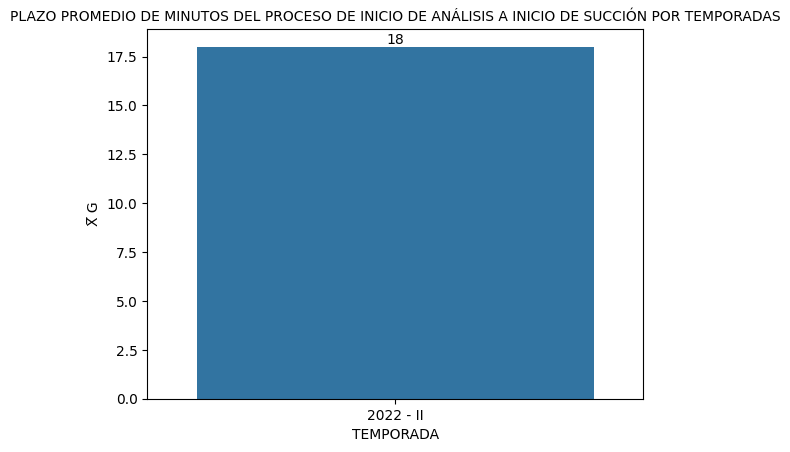

In [58]:
barplot_df('TEMPORADA','X̅ G',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE INICIO DE ANÁLISIS A INICIO DE SUCCIÓN POR TEMPORADAS')

In [59]:
df1 = df_tasa2[df_tasa2['ATIPICO_INIANALISIS_INISUCCION'] == 0][['PLANTA','TEMPORADA','INICIO_ANALISIS','INICIO_SUCCION']]
df1['G'] = (df1['INICIO_SUCCION'] - df1['INICIO_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','PLANTA'],as_index=False).agg({'G':'mean'})
df1.rename(columns = {'G':'X̅ G'}, inplace = True)
df1['X̅ G'] = df1['X̅ G'].round()
df1 = df1.sort_index()
df1

,TEMPORADA,PLANTA,X̅ G
0,2022 - II,CALLAO,15.0
1,2022 - II,CHIMBOTE,21.0
2,2022 - II,MALABRIGO,21.0
3,2022 - II,SAMANCO,19.0
4,2022 - II,SUPE,14.0
5,2022 - II,VEGUETA,19.0


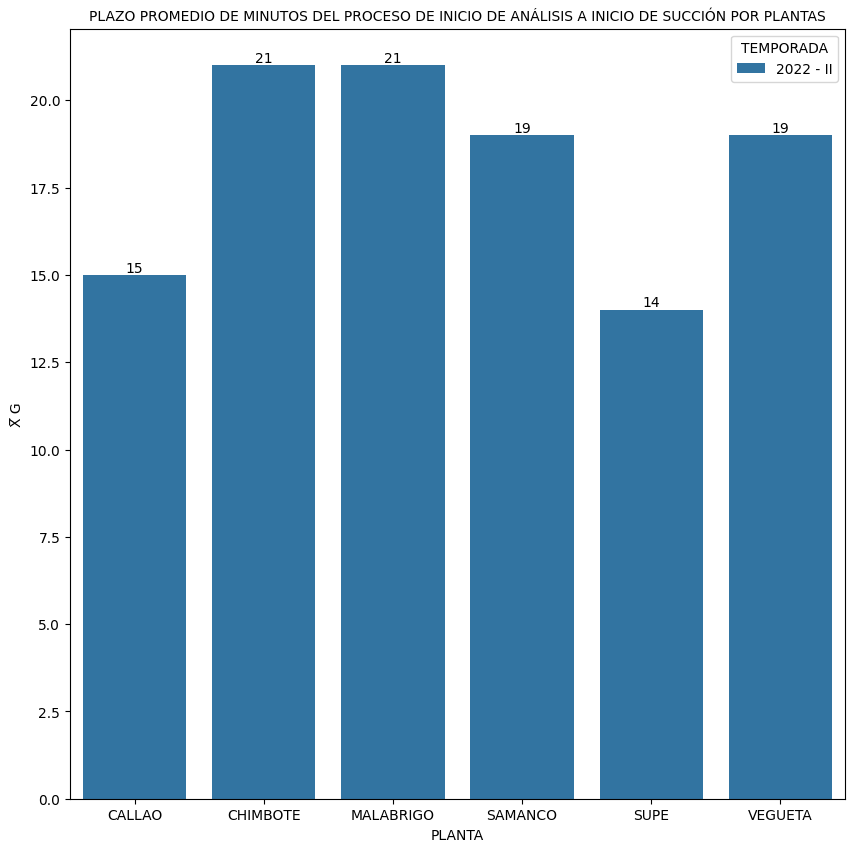

In [60]:
barplot_df_hue('PLANTA','X̅ G','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE INICIO DE ANÁLISIS A INICIO DE SUCCIÓN POR PLANTAS')